In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import re

from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, roc_curve, auc)

In [2]:
df = pd.read_csv("E:/ml/ml_notes/as4/as4/spam_ham_dataset.csv")

df

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\nth...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0
2,3624,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\nthis deal is to ...,0
...,...,...,...,...
5166,1518,ham,Subject: put the 10 on the ft\nthe transport v...,0
5167,404,ham,Subject: 3 / 4 / 2000 and following noms\nhpl ...,0
5168,2933,ham,Subject: calpine daily gas nomination\n>\n>\nj...,0
5169,1409,ham,Subject: industrial worksheets for august 2000...,0


In [3]:
print(df.columns
      )
df.drop(columns=['Unnamed: 0'],inplace=True)

print(df.head())
print(df.isnull().sum())

Index(['Unnamed: 0', 'label', 'text', 'label_num'], dtype='object')
  label                                               text  label_num
0   ham  Subject: enron methanol ; meter # : 988291\nth...          0
1   ham  Subject: hpl nom for january 9 , 2001\n( see a...          0
2   ham  Subject: neon retreat\nho ho ho , we ' re arou...          0
3  spam  Subject: photoshop , windows , office . cheap ...          1
4   ham  Subject: re : indian springs\nthis deal is to ...          0
label        0
text         0
label_num    0
dtype: int64


In [4]:
print(df.describe())
print(df.info())      

         label_num
count  5171.000000
mean      0.289886
std       0.453753
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      5171 non-null   object
 1   text       5171 non-null   object
 2   label_num  5171 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 121.3+ KB
None


In [5]:

X = df['text']
y = df['label_num']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTarget distribution:")
print(y.value_counts())

Features shape: (5171,)
Target shape: (5171,)

Target distribution:
label_num
0    3672
1    1499
Name: count, dtype: int64


In [6]:
print("Applying TF-IDF Vectorization...")
tfidf = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))
X_tfidf = tfidf.fit_transform(X)

print(f"TF-IDF Matrix Shape: {X_tfidf.shape}")


Applying TF-IDF Vectorization...
TF-IDF Matrix Shape: (5171, 5000)


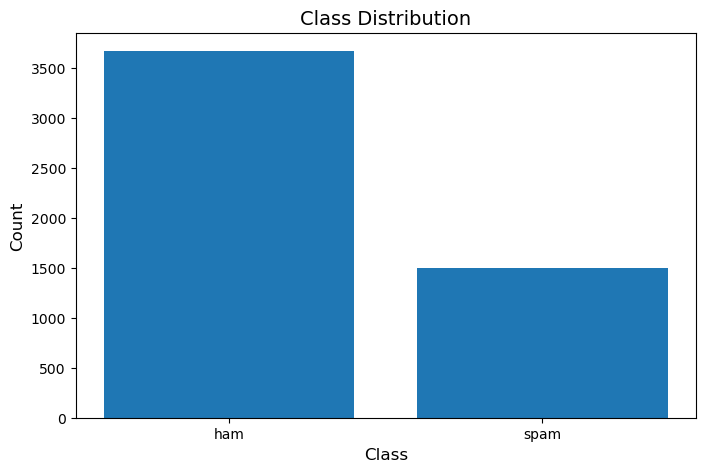

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))

class_counts = df['label'].value_counts()

ax.bar(class_counts.index, class_counts.values)

ax.set_title('Class Distribution', fontsize=14)
ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('Count', fontsize=12)


plt.savefig('class_distribution.png', dpi=150, bbox_inches='tight')

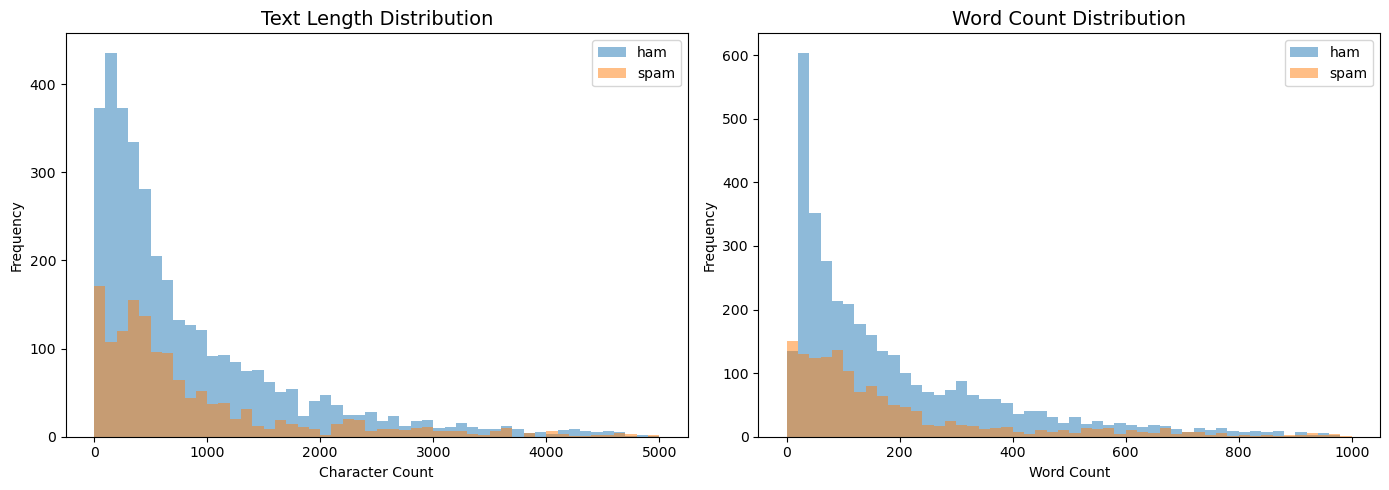

In [8]:
import matplotlib.pyplot as plt

df['text_length'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
labels = ['ham', 'spam']

for label in labels: 
    subset = df[df['label'] == label]
    axes[0].hist(subset['text_length'], bins=50, alpha=0.5, label=label, range=(0, 5000))

axes[0].set_title('Text Length Distribution', fontsize=14)
axes[0].set_xlabel('Character Count')
axes[0].set_ylabel('Frequency')
axes[0].legend()

for label in labels:
    subset = df[df['label'] == label]
    axes[1].hist(subset['word_count'], bins=50, alpha=0.5, label=label, range=(0, 1000))

axes[1].set_title('Word Count Distribution', fontsize=14)
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.tight_layout()
plt.savefig('text_length_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

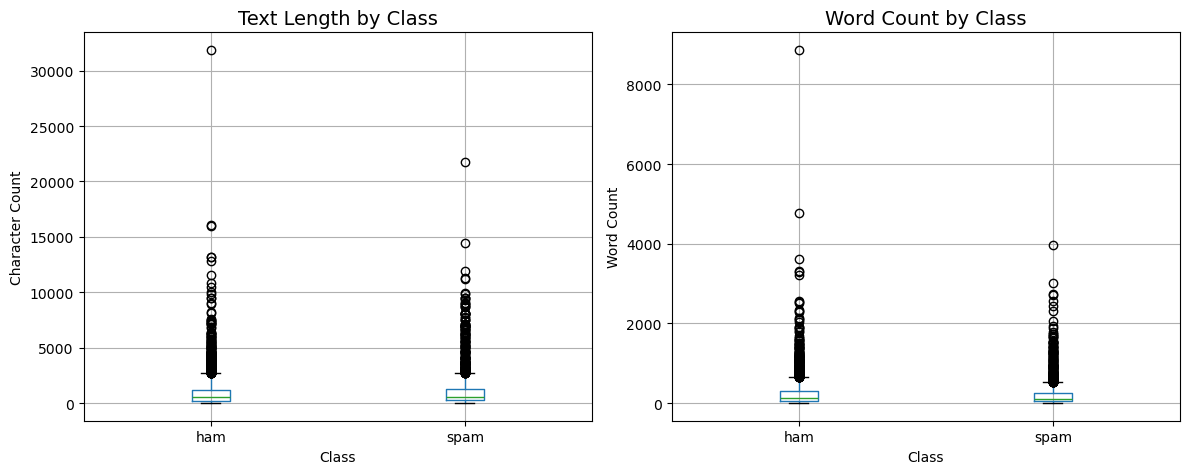

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

df.boxplot(column='text_length', by='label', ax=axes[0])
axes[0].set_title('Text Length by Class', fontsize=14)
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Character Count')

df.boxplot(column='word_count', by='label', ax=axes[1])
axes[1].set_title('Word Count by Class', fontsize=14)
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Word Count')

plt.suptitle('')
plt.tight_layout()
plt.savefig('text_boxplots.png', dpi=150, bbox_inches='tight')
plt.show()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


Training set: 4136 samples
Test set: 1035 samples


In [11]:

def plot_confusion_matrix(y_true, y_pred, title, ax):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

def plot_roc(y_true, y_proba, label, ax):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f'{label} (AUC={roc_auc:.3f})')
    return roc_auc

In [12]:

def calc_metrics(y_true, y_pred):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred)
    }

print("Training Baseline Logistic Regression")
lr_baseline = LogisticRegression(max_iter=1000, random_state=42)

start = time.time()
lr_baseline.fit(X_train, y_train)
lr_baseline_time = time.time() - start

y_predlrbase = lr_baseline.predict(X_test)
lr_baseline_metrics = calc_metrics(y_test, y_predlrbase)
lr_baseline_metrics['Training Time (s)'] = lr_baseline_time

print(f"\nBaseline Logistic Regression Results:")
for k, v in lr_baseline_metrics.items():
    print(f"  {k}: {v:.4f}")

Training Baseline Logistic Regression

Baseline Logistic Regression Results:
  Accuracy: 0.9816
  Precision: 0.9637
  Recall: 0.9733
  F1 Score: 0.9685
  Training Time (s): 0.0478


In [13]:
print("Tuning Logistic Regression Hyperparameters")

lr_params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

lr_grid = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    lr_params, cv=5, scoring='accuracy', n_jobs=-1, return_train_score=True
)

start = time.time()
lr_grid.fit(X_train, y_train)
lr_tune_time = time.time() - start

print(f"\nBest Parameters: {lr_grid.best_params_}")
print(f"Best CV Accuracy: {lr_grid.best_score_:.4f}")
print(f"Tuning Time: {lr_tune_time:.2f}s")

Tuning Logistic Regression Hyperparameters

Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV Accuracy: 0.9819
Tuning Time: 14.09s


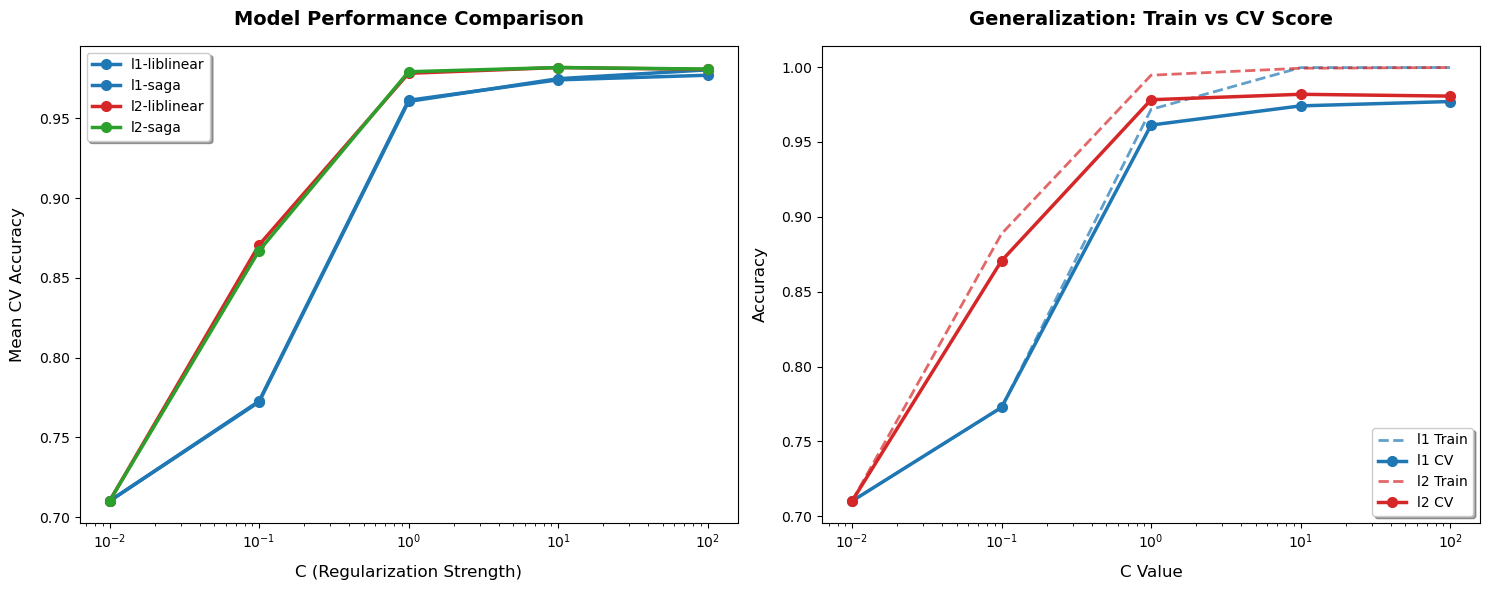

In [14]:
import matplotlib.pyplot as plt


lr_cv_results = pd.DataFrame(lr_grid.cv_results_)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

colors = {'l1-liblinear': '#1f77b4', 'l2-liblinear': '#d62728', 'l2-saga': '#2ca02c'}

for penalty in ['l1', 'l2']:
    for solver in ['liblinear', 'saga']:
        mask = (lr_cv_results['param_penalty'] == penalty) & (lr_cv_results['param_solver'] == solver)
        sub = lr_cv_results[mask]
        
        if len(sub) > 0:
            label_tag = f'{penalty}-{solver}'
            axes[0].plot(sub['param_C'], sub['mean_test_score'], 
                         marker='o', markersize=7, linewidth=2.5,
                         label=label_tag, color=colors.get(label_tag))

axes[0].set_xscale('log')
axes[0].set_xlabel('C (Regularization Strength)', fontsize=12, labelpad=10)
axes[0].set_ylabel('Mean CV Accuracy', fontsize=12, labelpad=10)
axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold', pad=15)
axes[0].legend(frameon=True, shadow=True, facecolor='white')


for penalty, color in zip(['l1', 'l2'], ['#1f77b4', '#d62728']):
    subset = lr_cv_results[(lr_cv_results['param_penalty'] == penalty) & 
                           (lr_cv_results['param_solver'] == 'liblinear')]
    
    if len(subset) > 0:
        axes[1].plot(subset['param_C'], subset['mean_train_score'], 
                     '--', linewidth=2, color=color, alpha=0.7, label=f'{penalty} Train')
        axes[1].plot(subset['param_C'], subset['mean_test_score'], 
                     '-o', linewidth=2.5, markersize=7, color=color, label=f'{penalty} CV')

axes[1].set_xscale('log')
axes[1].set_xlabel('C Value', fontsize=12, labelpad=10)
axes[1].set_ylabel('Accuracy', fontsize=12, labelpad=10)
axes[1].set_title('Generalization: Train vs CV Score', fontsize=14, fontweight='bold', pad=15)
axes[1].legend(frameon=True, shadow=True, facecolor='white', loc='lower right')

plt.tight_layout()
plt.savefig('lr_performance.png', dpi=150, bbox_inches='tight')
plt.show()

In [15]:
lr_best = lr_grid.best_estimator_
y_pred_lr = lr_best.predict(X_test)
y_proba_lr = lr_best.predict_proba(X_test)[:, 1]

lr_metrics = calc_metrics(y_test, y_pred_lr)
lr_metrics['Training Time (s)'] = lr_tune_time

print("\nTuned Logistic Regression Results:")
for k, v in lr_metrics.items():
    print(f"  {k}: {v:.4f}")


Tuned Logistic Regression Results:
  Accuracy: 0.9855
  Precision: 0.9766
  Recall: 0.9733
  F1 Score: 0.9750
  Training Time (s): 14.0858


In [16]:
kernels = ['linear', 'poly', 'rbf']
svm_kernel_results = {}

for kernel in kernels:
    print(f"Training SVM with {kernel} kernel")
    
    if kernel == 'poly':
        svm = SVC(kernel=kernel, degree=3, probability=True, random_state=42)
    else:
        svm = SVC(kernel=kernel, probability=True, random_state=42)
    
    start = time.time()
    svm.fit(X_train, y_train)
    train_time = time.time() - start
    
    y_pred = svm.predict(X_test)
    
    svm_kernel_results[kernel] = {
        'model': svm,
        'y_pred': y_pred,
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'Training Time (s)': train_time
    }

print("\nSVM Kernel Comparison:")
kernel_df = pd.DataFrame({k: {m: v[m] for m in ['Accuracy', 'F1 Score', 'Training Time (s)']} 
                          for k, v in svm_kernel_results.items()}).T
display(kernel_df.round(4))

Training SVM with linear kernel
Training SVM with poly kernel
Training SVM with rbf kernel

SVM Kernel Comparison:


,Accuracy,F1 Score,Training Time (s)
linear,0.9865,0.9767,6.4865
poly,0.9024,0.7976,27.7272
rbf,0.9874,0.9785,14.4396


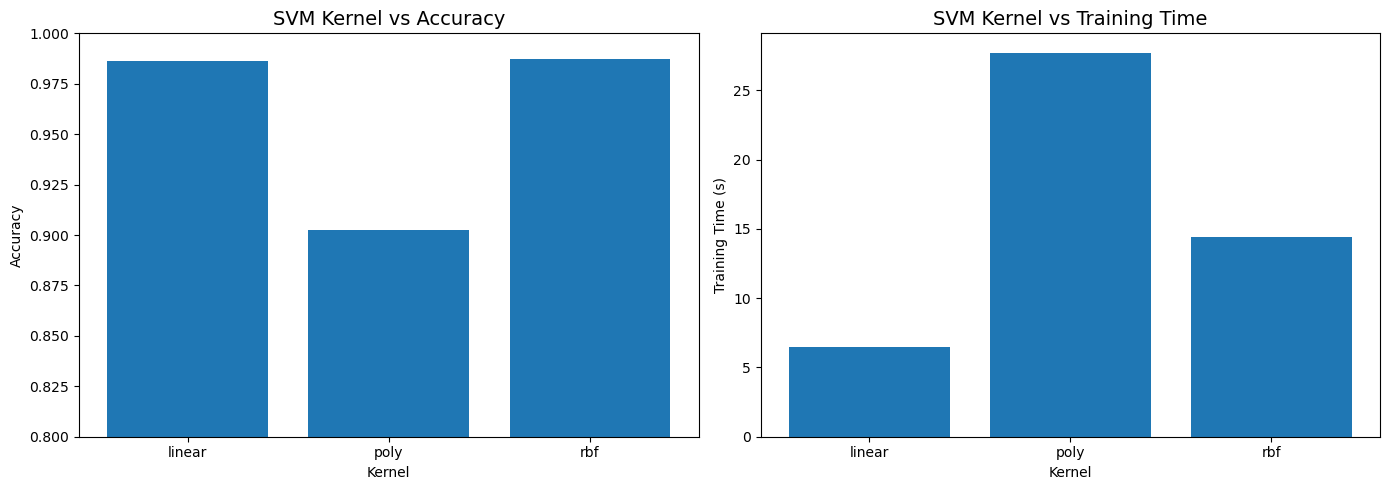

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

accuracies = [svm_kernel_results[k]['Accuracy'] for k in kernels]

axes[0].bar(kernels, accuracies)
axes[0].set_xlabel('Kernel')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('SVM Kernel vs Accuracy', fontsize=14)
axes[0].set_ylim([0.8, 1.0])

times = [svm_kernel_results[k]['Training Time (s)'] for k in kernels]
axes[1].bar(kernels, times)
axes[1].set_xlabel('Kernel')
axes[1].set_ylabel('Training Time (s)')
axes[1].set_title('SVM Kernel vs Training Time', fontsize=14)

plt.tight_layout()
plt.savefig('svm_kernel_comparison.png', dpi=150, bbox_inches='tight')
plt.show()


In [18]:
best_kernel = max(svm_kernel_results, key=lambda k: svm_kernel_results[k]['Accuracy'])
print(f"Best kernel: {best_kernel}")

print(f"\nTuning SVM with {best_kernel} kernel")

if best_kernel == 'poly':
    svm_params = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto'],
        'degree': [2, 3, 4]
    }
else:
    svm_params = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto']
    }

svm_grid = GridSearchCV(
    SVC(kernel=best_kernel, probability=True, random_state=42),
    svm_params, cv=5, scoring='accuracy', n_jobs=-1, return_train_score=True
)

start = time.time()
svm_grid.fit(X_train, y_train)
svm_tune_time = time.time() - start

print(f"\nBest Parameters: {svm_grid.best_params_}")
print(f"Best CV Accuracy: {svm_grid.best_score_:.4f}")
print(f"Tuning Time: {svm_tune_time:.2f}s")

Best kernel: rbf

Tuning SVM with rbf kernel

Best Parameters: {'C': 10, 'gamma': 'scale'}
Best CV Accuracy: 0.9850
Tuning Time: 114.94s


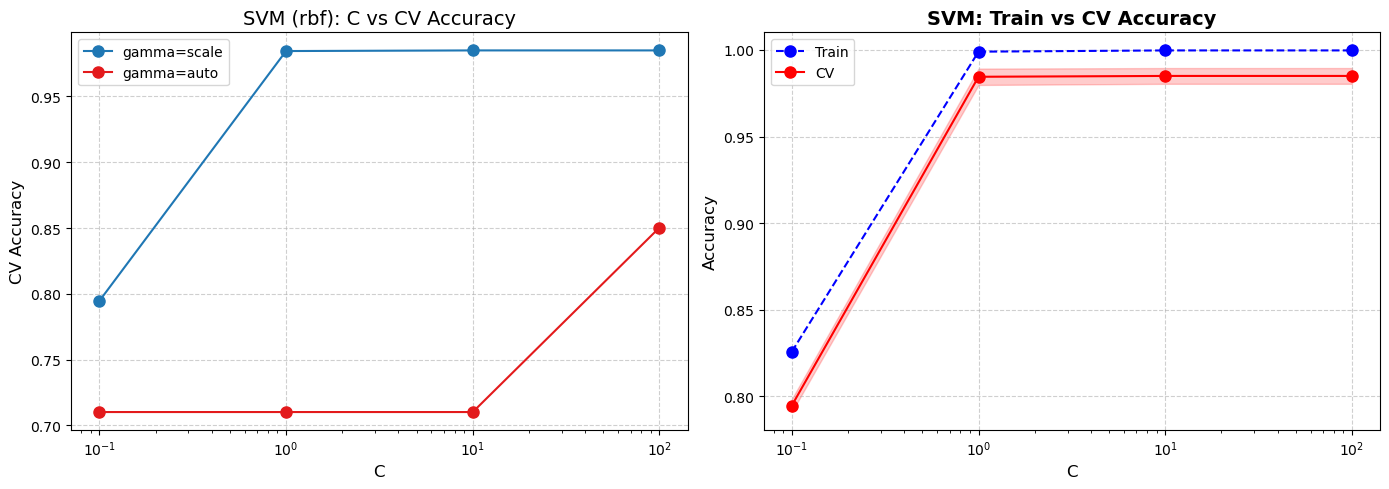

In [19]:
import matplotlib.pyplot as plt

svm_cv_results = pd.DataFrame(svm_grid.cv_results_)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors_p1 = ['#1f77b4', '#e31a1c'] 
for i, gamma in enumerate(['scale', 'auto']):
    subset = svm_cv_results[svm_cv_results['param_gamma'] == gamma]
    if len(subset) > 0:
        axes[0].plot(subset['param_C'], subset['mean_test_score'], '-o', 
                    label=f'gamma={gamma}', markersize=8, color=colors_p1[i])

axes[0].set_xscale('log')
axes[0].set_xlabel('C', fontsize=12)
axes[0].set_ylabel('CV Accuracy', fontsize=12)
axes[0].set_title(f'SVM ({best_kernel}): C vs CV Accuracy', fontsize=14)
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

subset = svm_cv_results[svm_cv_results['param_gamma'] == 'scale']
if len(subset) > 0:
    axes[1].plot(subset['param_C'], subset['mean_train_score'], 'b--o', label='Train', markersize=8)
    axes[1].plot(subset['param_C'], subset['mean_test_score'], 'r-o', label='CV', markersize=8)
   
    axes[1].fill_between(subset['param_C'],
                         subset['mean_test_score'] - subset['std_test_score'],
                         subset['mean_test_score'] + subset['std_test_score'],
                         alpha=0.2, color='red')

axes[1].set_xscale('log')
axes[1].set_xlabel('C', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('SVM: Train vs CV Accuracy', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig('svm_hyperparam_performance.png', dpi=150, bbox_inches='tight')
plt.show()

In [20]:
svm_best = svm_grid.best_estimator_
y_pred_svm = svm_best.predict(X_test)
y_proba_svm = svm_best.predict_proba(X_test)[:, 1]

svm_metrics = calc_metrics(y_test, y_pred_svm)
svm_metrics['Training Time (s)'] = svm_tune_time

print("\nTuned SVM Results:")
for k, v in svm_metrics.items():
    print(f"  {k}: {v:.4f}")


Tuned SVM Results:
  Accuracy: 0.9855
  Precision: 0.9734
  Recall: 0.9767
  F1 Score: 0.9750
  Training Time (s): 114.9432


In [21]:
tuning_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'SVM'],
    'Search Method': ['Grid Search', 'Grid Search'],
    'Best Parameters': [str(lr_grid.best_params_), str(svm_grid.best_params_)],
    'Best CV Accuracy': [lr_grid.best_score_, svm_grid.best_score_]
})

print("HYPERPARAMETER TUNING RESULTS")
display(tuning_df)

HYPERPARAMETER TUNING RESULTS


,Model,Search Method,Best Parameters,Best CV Accuracy
0,Logistic Regression,Grid Search,"{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}",0.981868
1,SVM,Grid Search,"{'C': 10, 'gamma': 'scale'}",0.985010


In [22]:
print("Logistic Regression Performance Table")

lr_perf_df = pd.DataFrame({'Metric': list(lr_metrics.keys()), 'Value': list(lr_metrics.values())})

print("LOGISTIC REGRESSION PERFORMANCE")

display(lr_perf_df.round(4))

Logistic Regression Performance Table
LOGISTIC REGRESSION PERFORMANCE


,Metric,Value
0,Accuracy,0.9855
1,Precision,0.9766
2,Recall,0.9733
3,F1 Score,0.9750
4,Training Time (s),14.0858


In [23]:
svm_kernel_df = pd.DataFrame({k: {m: v[m] for m in ['Accuracy', 'F1 Score', 'Training Time (s)']} 
                               for k, v in svm_kernel_results.items()}).T
svm_kernel_df.index.name = 'Kernel'


print("SVM KERNEL-WISE PERFORMANCE")

display(svm_kernel_df.round(4))

SVM KERNEL-WISE PERFORMANCE


,Accuracy,F1 Score,Training Time (s)
Kernel,,,
linear,0.9865,0.9767,6.4865
poly,0.9024,0.7976,27.7272
rbf,0.9874,0.9785,14.4396


In [24]:
print("Performing 5-Fold Cross-Validation...")
from sklearn.model_selection import cross_val_score
lr_cv_scores = cross_val_score(lr_best, X_train, y_train, cv=5, scoring='accuracy')
svm_cv_scores = cross_val_score(svm_best, X_train, y_train, cv=5, scoring='accuracy')

cv_results_df = pd.DataFrame({
    'Fold': [f'Fold {i+1}' for i in range(5)] + ['Average'],
    'Logistic Regression': list(lr_cv_scores) + [lr_cv_scores.mean()],
    'SVM': list(svm_cv_scores) + [svm_cv_scores.mean()]
})


print("K-FOLD CROSS-VALIDATION RESULTS (K=5)")

display(cv_results_df.round(4))

Performing 5-Fold Cross-Validation...
K-FOLD CROSS-VALIDATION RESULTS (K=5)


,Fold,Logistic Regression,SVM
0,Fold 1,0.9771,0.9843
1,Fold 2,0.9867,0.9867
2,Fold 3,0.9746,0.9794
3,Fold 4,0.9915,0.9927
4,Fold 5,0.9794,0.9819
5,Average,0.9819,0.9850


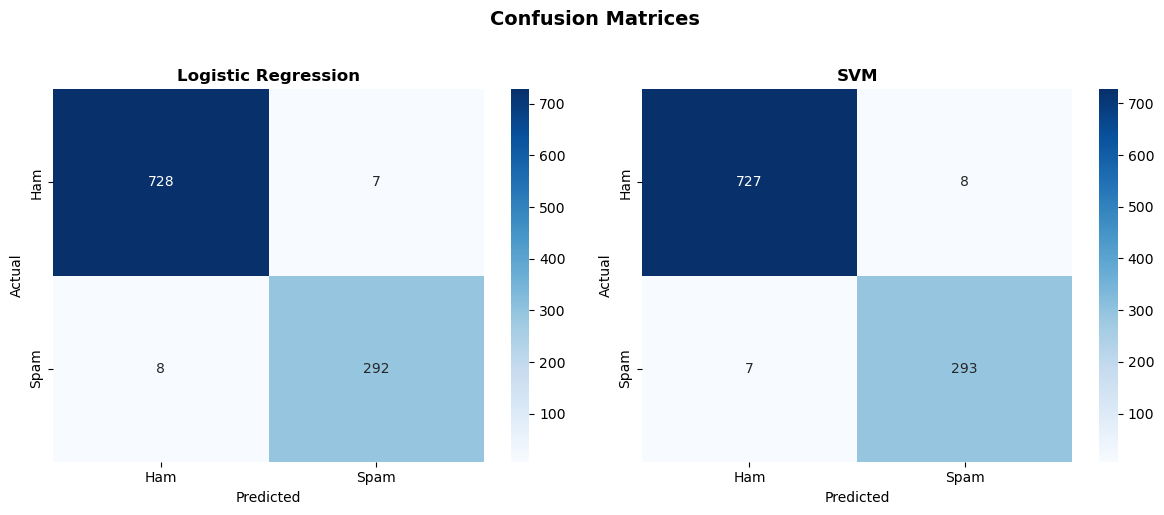

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
def plot_confusion_matrix(y_true, y_pred, title, ax):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
plot_confusion_matrix(y_test, y_pred_lr, 'Logistic Regression', axes[0])
plot_confusion_matrix(y_test, y_pred_svm, 'SVM', axes[1])

plt.suptitle('Confusion Matrices', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

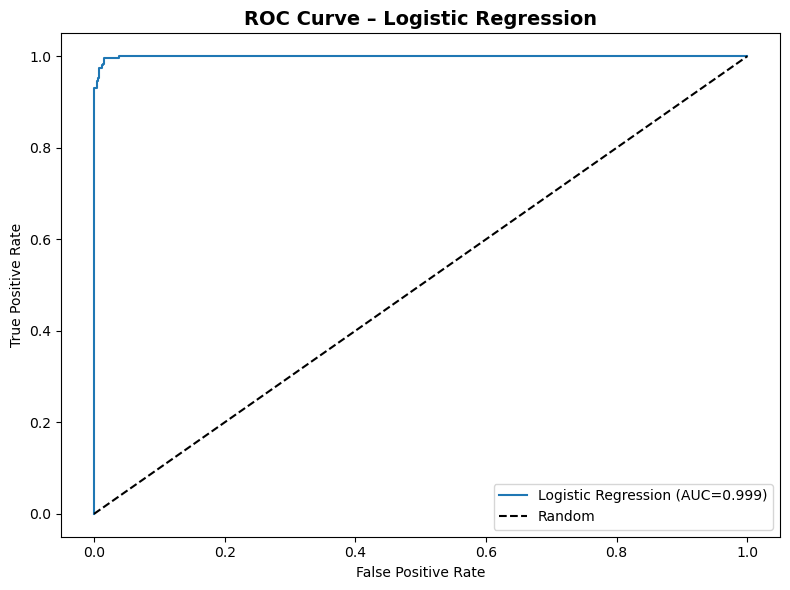

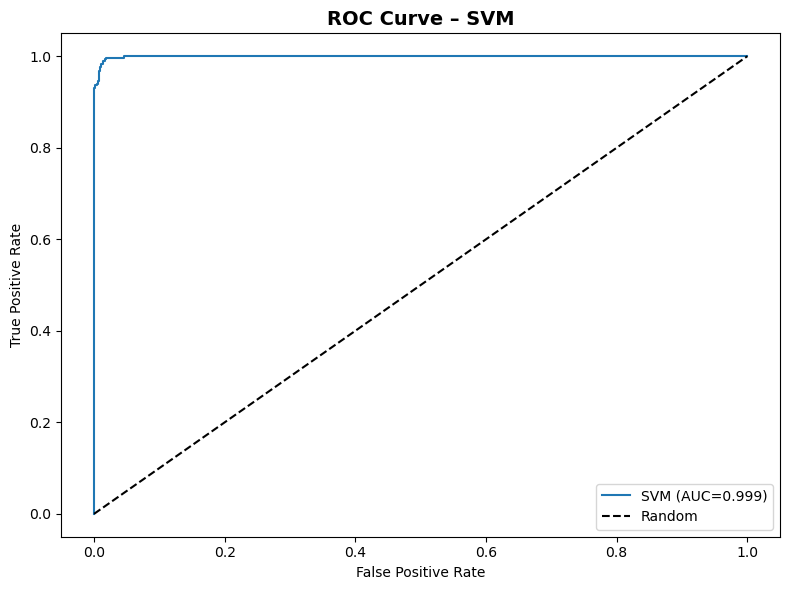

In [26]:

def plot_roc(y_true, y_proba, label, ax):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f'{label} (AUC={roc_auc:.3f})')
    return roc_auc

fig, ax = plt.subplots(figsize=(8, 6))
plot_roc(y_test, y_proba_lr, 'Logistic Regression', ax)

ax.plot([0, 1], [0, 1], 'k--', label='Random')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve – Logistic Regression', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')

plt.tight_layout()
plt.savefig('roc_lr.png', dpi=150, bbox_inches='tight')
plt.show()


fig, ax = plt.subplots(figsize=(8, 6))
plot_roc(y_test, y_proba_svm, 'SVM', ax)

ax.plot([0, 1], [0, 1], 'k--', label='Random')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve – SVM', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')

plt.tight_layout()
plt.savefig('roc_svm.png', dpi=150, bbox_inches='tight')
plt.show()


In [27]:
comparison_df = pd.DataFrame({
    'Criterion': ['Accuracy', 'Model Complexity', 'Training Time', 'Interpretability'],
    'Logistic Regression': [
        f"{lr_metrics['Accuracy']:.4f}",
        'Low',
        f"{lr_metrics['Training Time (s)']:.2f}s",
        'High'
    ],
    'SVM': [
        f"{svm_metrics['Accuracy']:.4f}",
        'High',
        f"{svm_metrics['Training Time (s)']:.2f}s",
        'Low'
    ]
})


print("COMPARATIVE ANALYSIS")

display(comparison_df)

COMPARATIVE ANALYSIS


,Criterion,Logistic Regression,SVM
0,Accuracy,0.9855,0.9855
1,Model Complexity,Low,High
2,Training Time,14.09s,114.94s
3,Interpretability,High,Low


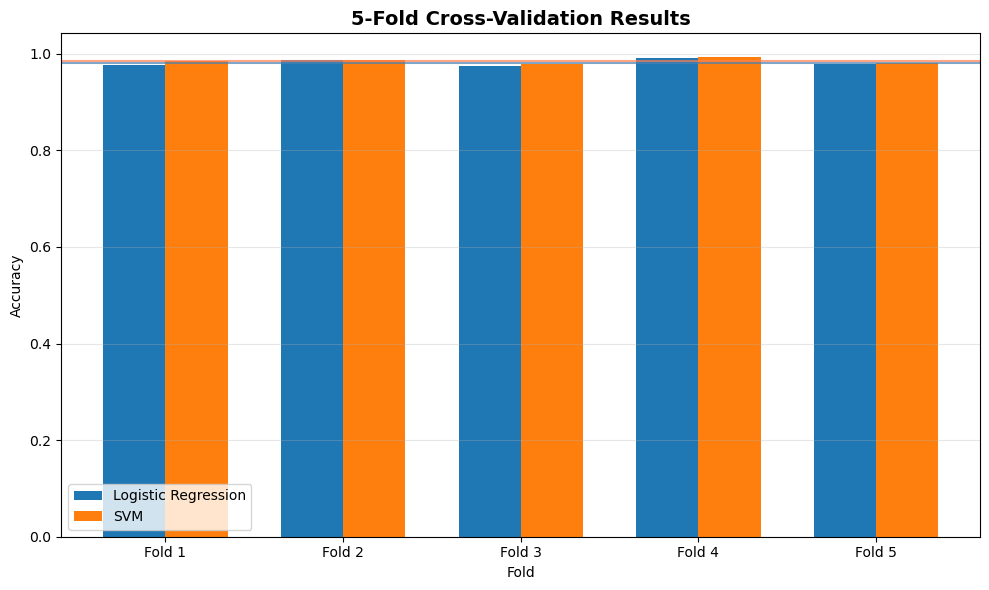

In [29]:
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(5)
width = 0.35

ax.bar(x - width/2, lr_cv_scores, width, label='Logistic Regression')
ax.bar(x + width/2, svm_cv_scores, width, label='SVM')

ax.axhline(y=lr_cv_scores.mean(), color='steelblue', alpha=0.7)
ax.axhline(y=svm_cv_scores.mean(), color='coral', alpha=0.7)

ax.set_xlabel('Fold')
ax.set_ylabel('Accuracy')
ax.set_title('5-Fold Cross-Validation Results', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f'Fold {i+1}' for i in range(5)])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('cv_results.png', dpi=150, bbox_inches='tight')
plt.show()